## Adversarial Examples on Randomized Smoothing-Defended Models

This notebook contains the main code used to test the efficacy of different adversarial attacks on undefended models and on models defended with Randomized Smoothing as proposed by [Cohen et al., 2019](https://arxiv.org/abs/1902.02918).

### Mount Google Drive; import packages

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import packages
import os
import sys

# torch for ResNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.v2 as transforms

from torchvision import models

# smoothing
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/CPSC486/scripts') # for randomized smoothing scripts
import core

# visualization
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


In [ ]:
# for device handling
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# directories and paths
SOME_DATA_FOLDER = './drive/MyDrive/Colab Notebooks/CPSC486/some_images/'
FULL_DATA_FOLDER = './drive/MyDrive/Colab Notebooks/CPSC486/images/'
CLASSNAMES_FILE = './drive/MyDrive/Colab Notebooks/CPSC486/imagenet_classnames.txt'

### Set up baseline ResNet model and inputs

In [ ]:
# image processing
def unnormalize(img):
    r"""
    Args:
        img (Tensor): Tensor image of size (C, H, W), normalized according to means, stds.
    Returns:
        numpy.ndarray: Unnormalized image of size (H, W, C) in range [0, 1].
    """
    # Convert the Tensor img to a numpy array that can be visualized
    img = img.cpu().permute(1, 2, 0).numpy()
    img = (img * stds[None,None]) + means[None,None]
    img = np.clip(img, a_min=0.0, a_max=1.0)
    print(img.shape)
    return img

# Transformations applied to images before passing them to the model
# Pretrained normalization based on https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
means, stds = [0.485, 0.456, 0.406], [0.485, 0.456, 0.406]
means, stds = np.array(means), np.array(stds)

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToImage(), # Converts to tensor
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=means, std=stds)
    ]
)

# Load the small dataset
dataset = torchvision.datasets.ImageFolder(SOME_DATA_FOLDER, transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# class names
# my classes is only used for our reference to the dataset labels.
my_classes = ('English springer', 'cassette player', 'chain saw', 'church',
              'french horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench') # should match dataset labels

# classes should be used for ResNet model outputs
classes = [] # 1000 resnet output classes
with open(CLASSNAMES_FILE, 'r') as f:
    for line in f:
        classes.append(line.strip())

In [ ]:
# ----- load ResNet model ----- #
# load in baseline ResNet model
net = models.resnet18(weights='DEFAULT').to(DEVICE)
net.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

(454, 1810, 3)


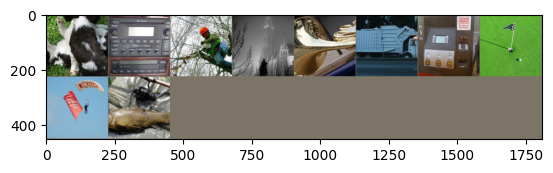

GroundTruth:  English springer cassette player chain saw church french horn garbage truck gas pump golf ball parachute tench
Predicted:  English springer tape player bee eater mosquito net French horn garbage truck cash machine safety pin parachute tench
Predicted ID:    217   848    92   669   566   569   480   772   701     0


In [ ]:
# ----- check models and inputs are working ----- #
# Load images and labels from the dataset
images_ = torch.stack([dataset[20*i][0] for i in range(len(my_classes))]).to(DEVICE)
labels_ = [dataset[20*i][1] for i in range(len(my_classes))]

# Show images
plt.imshow(unnormalize(torchvision.utils.make_grid(images_)))
plt.show()
print("GroundTruth: ", " ".join("%5s" % my_classes[labels_[j]] for j in range(len(my_classes))))

# Predictions
outputs_ = net(images_)
_, predicted_ = torch.max(outputs_, 1)
print("Predicted: ", " ".join("%5s" % classes[predicted_[j]] for j in range(len(my_classes))))
print("Predicted ID: ", " ".join("%5s" % predicted_[j].item() for j in range(len(my_classes)))) # added index

## Main testing

In [ ]:
# hyperparameters for smoothed model
SIGMA = 0.05 # variance of gaussian noise added to model input
ALPHA = 0.001 # level of statistical significance
N_PREDICT = 100
N_CERTIFY = 10000
BATCH_SIZE = 16

# initialize smoothed ResNet model
net_smooth = core.Smooth(net, len(classes), SIGMA)

### Step 1: For input images, compute predictions and certified radii

In [ ]:
# list for outputs; preserve order!
base_predicted_labels = []
base_smooth_predicted_labels = []
base_smooth_certified_radii = []

# loop and compute predictions with certified radii
i = 0
for (image, label) in dataset:
    image = image.to(DEVICE)
    image_unsq = torch.unsqueeze(image, dim=0)

    # base ResNet model predictions
    resnet_output = net(image_unsq)
    _, resnet_pred = torch.max(resnet_output, 1)
    base_predicted_labels.append(resnet_pred.item())

    # smooth model predictions
    smooth_pred, smooth_radius = net_smooth.certify(image, N_PREDICT, N_CERTIFY, ALPHA, batch_size=BATCH_SIZE)
    base_smooth_predicted_labels.append(smooth_pred)
    base_smooth_certified_radii.append(smooth_radius)

    if i%10 == 0:
      print(f"{i} of 200 done")
    # break

    i += 1



0 of 200 done
10 of 200 done
20 of 200 done
30 of 200 done
40 of 200 done
50 of 200 done
60 of 200 done
70 of 200 done
80 of 200 done
90 of 200 done
100 of 200 done
110 of 200 done
120 of 200 done
130 of 200 done
140 of 200 done
150 of 200 done
160 of 200 done
170 of 200 done
180 of 200 done
190 of 200 done


In [ ]:
# save to avoid recomputing
import pandas as pd

# - to save - #
# base_df = pd.DataFrame({'image_id':list(range(1,len(dataset)+1)), 'ResNet_labels': base_predicted_labels, 'smooth_labels': base_smooth_predicted_labels, 'smooth_radius': base_smooth_certified_radii})
# base_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CPSC486/sigma_05_results.csv', index=False)

# - to load - #
base_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CPSC486/sigma_05_results.csv')

In [ ]:
base_df.head()

,image_id,ResNet_labels,smooth_labels,smooth_radius
0,1,217,217,0.117742
1,2,217,217,0.159929
2,3,217,217,0.159929
3,4,217,217,0.159929
4,5,217,217,0.159929


### Step 2: Test 4 adversarial attack methods.
Go through interval of l2 norm bounds and run attacks at each l2 norm level. See if these match up with claimed certified radii. Linear search with high precision (for plotting).

#### Implement 4 attacks

In [ ]:
def fgsm_rescaled_adv(model, img, label, l2_norm):
    r"""
    Args:
        model (nn.Module): Baseline model to attack, e.g. self.model in the LResnet definition.
        imgs (Tensor): Tensor of one image. Size (C, H, W). Normalized according to means, stds.
        labels (Tensor): Int label in [0, NUM_CLASSES).
        l2_norm (float): Desired l2 norm of deviation from the input images
    Returns:
        adv_img (Tensor): Adversarial image. Same dimensions and normalization as imgs. Detached.
            Each adversarial image in the batch is l2 distance equal to l2_norm away from the original image.
            Images generated by the Fast Gradient Sign Method (FGSM).
    """
    model.eval() # ResNet in our case
    loss_to_use = nn.CrossEntropyLoss()

    # - compute loss - #
    # print(img.shape)
    # temp = torch.unsqueeze(img,0).clone().detach().requires_grad_(True)
    # print(temp.shape)
    # print(temp)

    # img = torch.unsqueeze(img,0).to(DEVICE)
    img = torch.unsqueeze(img,0).clone().detach().requires_grad_(True).to(DEVICE)
    output = model(img) # [1, 1000]
    loss = loss_to_use(output, torch.unsqueeze(torch.tensor(label),0).to(DEVICE))

    # - compute gradient - #
    gradient = torch.autograd.grad(outputs=loss, inputs=img)[0] # [1, 3, 224, 224]

    # - compute adversarial image - #
    gradient_signed = torch.sign(gradient) # 1 * 3 * 224 * 224; want to normalize across dimension 0
    l2_norm_gradient_signed = F.normalize(gradient_signed, p=2.0, dim=(1,2,3))
    adv_img = img + l2_norm * l2_norm_gradient_signed

    # print(f"new loss: {loss_to_use(model(adv_img), torch.unsqueeze(torch.tensor(label),0).to(DEVICE))}")

    return adv_img.detach() # returns attacked image


def gradient_rescaled_adv(model, img, label, l2_norm):
    r"""
    Args:
        model (nn.Module): Baseline model to attack, e.g. self.model in the LResnet definition.
        imgs (Tensor): Tensor of image. Size (C, H, W). Normalized according to means, stds.
        labels (Tensor): Int label in [0, NUM_CLASSES).
        l2_norm (float): Desired l2 norm of deviation from the input images
    Returns:
        adv_img (Tensor): Adversarial image. Same dimensions and normalization as imgs. Detached.
            Each adversarial image in the batch is l2 distance equal to l2_norm away from the original image.
            Images generated by the Fast Gradient Sign Method (FGSM).
    """
    model.eval() # ResNet in our case
    loss_to_use = nn.CrossEntropyLoss()

    # - compute loss - #
    img = torch.unsqueeze(img,0).clone().detach().requires_grad_(True).to(DEVICE)
    output = model(img) # [1, 1000]
    loss = loss_to_use(model(img), torch.unsqueeze(torch.tensor(label),0).to(DEVICE))

    # - compute gradient - #
    gradient = torch.autograd.grad(outputs=loss, inputs=img)[0] # [1, 3, 224, 224]

    # - compute adversarial images - #
    l2_norm_gradient = F.normalize(gradient, p=2.0, dim=(1,2,3)) # 1 * 3 * 224 * 224
    adv_img = img + l2_norm * l2_norm_gradient

    # print(f"new loss: {loss_to_use(model(adv_img), torch.unsqueeze(torch.tensor(label),0).to(DEVICE))}")

    return adv_img.detach() # returns attacked image

In [ ]:
def pgd_sign(model, img, label, l2_norm, eps=1/255):
    model.eval()
    loss_to_use = nn.CrossEntropyLoss()

    # for PGD
    tolerance = 0.01
    max_iter = 30
    iters = 0 # iteration counter
    loss = 0
    prev_loss = 0

    proposed_adv_img = torch.unsqueeze(img,0).clone().detach().requires_grad_(True).to(DEVICE)
    img = img.to(DEVICE)

    # for max_iter iterations,
    for i in range(max_iter):
        # model output
        output = model(proposed_adv_img)

        # compute loss
        loss = loss_to_use(model(proposed_adv_img), torch.unsqueeze(torch.tensor(label),0).to(DEVICE))

        # if i > 1:
        #     print(f"{loss.item()} {prev_loss.item()}")

        # break if loss didn't change much
        if i > 1 and prev_loss.item() - loss.item() > tolerance:
            print(f"pgd stopped early at {i} out of {max_iter}")
            break

        # compute signed gradient
        gradient = torch.autograd.grad(outputs=loss, inputs=proposed_adv_img)[0] # grab gradient
        gradient_signed = torch.sign(gradient) # 1 * 3 * 224 * 224;

        # take step
        proposed_adv_img = proposed_adv_img + eps * gradient_signed

        # project back onto l2_norm ball if needed
        diff_from_img = proposed_adv_img - img
        if torch.norm(diff_from_img, p=2.0) > l2_norm:
            proposed_adv_img = img + l2_norm * F.normalize(diff_from_img, p=2.0, dim=(1,2,3))

        prev_loss = loss

    # print(f"new loss: {loss_to_use(model(proposed_adv_img), torch.unsqueeze(torch.tensor(label),0).to(DEVICE))}")

    return proposed_adv_img.detach()


def pgd_grad(model, img, label, l2_norm, eps=1/255):
    model.eval()
    loss_to_use = nn.CrossEntropyLoss()

    # for PGD
    tolerance = 0.01
    max_iter = 30
    iters = 0 # iteration counter
    loss = 0
    prev_loss = 0

    proposed_adv_img = torch.unsqueeze(img,0).clone().detach().requires_grad_(True).to(DEVICE)
    img = img.to(DEVICE)

    # for max_iter iterations,
    for i in range(max_iter):
        # model output
        output = model(proposed_adv_img)

        # compute loss
        loss = loss_to_use(model(proposed_adv_img), torch.unsqueeze(torch.tensor(label),0).to(DEVICE))

        # if i>1:
        #     print(f"{loss.item()} {prev_loss.item()}")

        # break if loss didn't change much
        if i > 1 and prev_loss.item() - loss.item() > tolerance:
            print(f"pgd stopped early at {i} out of {max_iter}")
            break

        # compute signed gradient
        gradient = torch.autograd.grad(outputs=loss, inputs=proposed_adv_img)[0] # grab gradient

        # take step
        proposed_adv_img = proposed_adv_img + eps * gradient

        # project back onto l2_norm ball if needed
        diff_from_img = proposed_adv_img - img
        if torch.norm(diff_from_img, p=2.0) > l2_norm:
            proposed_adv_img = img + l2_norm * F.normalize(diff_from_img, p=2.0, dim=(1,2,3))

        prev_loss = loss

    # print(f"new loss: {loss_to_use(model(proposed_adv_img), torch.unsqueeze(torch.tensor(label),0).to(DEVICE))}")

    return proposed_adv_img.detach()


#### Linear search of model predictions

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# hyperparameters
search_vals = np.linspace(0.1, 2, 20)

net_attack_outputs = pd.DataFrame(columns = ['id', 'val', 'fgsm_rescaled_pred', 'grad_rescaled_pred', 'pgd_sign_pred', 'pgd_grad_pred'])
smooth_attack_outputs = pd.DataFrame(columns = ['id', 'val', 'fgsm_rescaled_pred', 'grad_rescaled_pred', 'pgd_sign_pred', 'pgd_grad_pred'])
# df = df.append(pd.Series(new_row, index=df.columns), ignore_index=True)

for i in range(len(dataset)):
    # halved
    if i%2 == 1 or i < 130:
        continue
    # grab known data for instance
    img = dataset[i][0]
    lab = dataset[i][1] # mine; don't use!
    base_pred = base_df.at[i, 'ResNet_labels']
    smooth_pred = base_df.at[i, 'smooth_labels']
    smooth_radius = base_df.at[i, 'smooth_radius']

    # print(torch.isnan(img).any().item())
    # print(torch.isinf(img).any().item())

    # print(i)

    # print(img)
    # print(smooth_pred)
    # print(l2_norm)

    for val in search_vals:
        l2_norm = val * smooth_radius # allowed perturbation (l2 norm)

        # print(l2_norm)

        # compute 4 adversarial images for given l2 attack
        fgsm_rescaled_img = fgsm_rescaled_adv(net, img, base_pred, l2_norm).to(DEVICE) # trying to get the smooth prediction wrong
        grad_rescaled_img = gradient_rescaled_adv(net, img, base_pred, l2_norm).to(DEVICE)
        pgd_sign_img = pgd_sign(net, img, base_pred, l2_norm).to(DEVICE)
        pgd_grad_img = pgd_grad(net, img, base_pred, l2_norm).to(DEVICE)

        # record predictions made by base model and smoothed model
        _, base_fgsm_rescaled_pred = torch.max(net(fgsm_rescaled_img), 1)
        _, base_grad_rescaled_pred = torch.max(net(grad_rescaled_img), 1)
        _, base_pgd_sign_pred = torch.max(net(pgd_sign_img), 1)
        _, base_pgd_grad_pred = torch.max(net(pgd_grad_img), 1)

        base_preds = [base_fgsm_rescaled_pred.item(), base_grad_rescaled_pred.item(), base_pgd_sign_pred.item(), base_pgd_sign_pred.item()]

        base_new_row = [i, val] + base_preds
        net_attack_outputs.loc[len(net_attack_outputs)] = base_new_row

        # print(base_preds)

        smooth_fgsm_rescaled_pred = net_smooth.predict(torch.squeeze(fgsm_rescaled_img), N_PREDICT, ALPHA, BATCH_SIZE)
        smooth_grad_rescaled_pred = net_smooth.predict(torch.squeeze(grad_rescaled_img), N_PREDICT, ALPHA, BATCH_SIZE)
        smooth_pgd_sign_pred = net_smooth.predict(torch.squeeze(pgd_sign_img), N_PREDICT, ALPHA, BATCH_SIZE)
        smooth_pgd_grad_pred = net_smooth.predict(torch.squeeze(pgd_grad_img), N_PREDICT, ALPHA, BATCH_SIZE)

        smooth_preds = [smooth_fgsm_rescaled_pred, smooth_grad_rescaled_pred, smooth_pgd_sign_pred, smooth_pgd_grad_pred]

        smooth_new_row = [i, val] + smooth_preds
        smooth_attack_outputs.loc[len(smooth_attack_outputs)] = smooth_new_row

        # break

    # progress
    if i%10 == 0:
        print(f"{i} out of 200 (double speed)")

    # break

130 out of 200 (double speed)
pgd stopped early at 4 out of 30
pgd stopped early at 4 out of 30
140 out of 200 (double speed)
150 out of 200 (double speed)
160 out of 200 (double speed)
pgd stopped early at 6 out of 30
pgd stopped early at 4 out of 30
pgd stopped early at 4 out of 30
pgd stopped early at 4 out of 30
pgd stopped early at 4 out of 30
pgd stopped early at 4 out of 30
170 out of 200 (double speed)
180 out of 200 (double speed)
190 out of 200 (double speed)
pgd stopped early at 28 out of 30
pgd stopped early at 8 out of 30


In [ ]:
# net_attack_outputs.to_csv('/content/drive/MyDrive/Colab Notebooks/CPSC486/net_attack_outputs.csv', index=False)

In [ ]:
net_attack_outputs

,id,val,fgsm_rescaled_pred,grad_rescaled_pred,pgd_sign_pred,pgd_grad_pred
0,130.0,0.1,412.0,412.0,412.0,412.0
1,130.0,0.2,412.0,412.0,412.0,412.0
2,130.0,0.3,412.0,412.0,412.0,412.0
3,130.0,0.4,412.0,412.0,412.0,412.0
4,130.0,0.5,412.0,412.0,412.0,412.0
...,...,...,...,...,...,...
695,198.0,1.6,0.0,0.0,0.0,0.0
696,198.0,1.7,0.0,0.0,0.0,0.0
697,198.0,1.8,0.0,0.0,0.0,0.0
698,198.0,1.9,0.0,0.0,0.0,0.0


In [ ]:
# smooth_attack_outputs.to_csv('/content/drive/MyDrive/Colab Notebooks/CPSC486/smooth_attack_outputs.csv', index=False)

In [ ]:
smooth_attack_outputs

,id,val,fgsm_rescaled_pred,grad_rescaled_pred,pgd_sign_pred,pgd_grad_pred
0,130.0,0.1,-1.0,-1.0,-1.0,-1.0
1,130.0,0.2,-1.0,-1.0,-1.0,-1.0
2,130.0,0.3,-1.0,-1.0,-1.0,-1.0
3,130.0,0.4,-1.0,-1.0,-1.0,-1.0
4,130.0,0.5,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...
695,198.0,1.6,0.0,0.0,0.0,0.0
696,198.0,1.7,0.0,0.0,0.0,0.0
697,198.0,1.8,0.0,0.0,0.0,0.0
698,198.0,1.9,0.0,0.0,0.0,0.0
